In [1]:

import numpy as np
import pymc as pm
import arviz as az
import math
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
import matplotlib.cm as cm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Normal-Gamma Model

In [2]:
n = 20

# mean
mu_prior_mu = 0
mu_prior_sigma = 1
mu0 = 0

#variance
alpha0 = 1
beta0 = 1
phi0 = 1

In [3]:
def normal_logp_pm(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5*np.log(2*np.pi)

## Bias Against

### Hypothesis

In [26]:
with pm.Model() as m:
   
    mu_ = pm.Normal('mu_', mu=mu_prior_mu, sigma=mu_prior_sigma, shape=1)    
    phi_ = pm.Gamma("phi_", alpha = alpha0, beta = beta0, shape = 1)
    
    # Bias against
    x_ = pm.Normal('x_', mu=mu_, tau=phi_, shape=n) 
    
    # Prior predictive data density evaluations
    prior_pd_mu = pm.Deterministic("prior_pd_mu", normal_logp_pm(mu0,mu_prior_mu,mu_prior_sigma))
    prior_pd_phi = pm.Deterministic("prior_pd_phi", pm.logp(pm.Gamma.dist(alpha=alpha0, beta=beta0),phi0))
    
    # Posterior calculations
    posterior_tau = (1/mu_prior_sigma**2 + n*phi0)
    posterior_mu = (mu_prior_mu/mu_prior_sigma**2 + phi0*pm.math.sum(x_))/posterior_tau
    posterior_pd_mu = pm.Deterministic("posterior_pd_mu", pm.logp(pm.Normal.dist(mu = posterior_mu, tau = posterior_tau),mu0))
    
    posterior_alpha = alpha0 + n/2
    posterior_beta = beta0 + pm.math.sum((x_-mu0)**2)/2
    posterior_pd_phi = pm.Deterministic("posterior_pd_phi", pm.logp(pm.Gamma.dist(alpha=posterior_alpha, beta=posterior_beta),phi0))

    # log RB ratio
    logRB_mu = pm.Deterministic("logRB_mu", posterior_pd_mu - prior_pd_mu)
    logRB_phi = pm.Deterministic("logRB_phi", posterior_pd_phi - prior_pd_phi)
    
    #likelihood_pd = pm.Deterministic("likelihood_pd", normal_logpp_pm(x_,mu0,1/phi0**(1/2)).sum())
    likelihood_pd = pm.Deterministic("likelihood_pd", normal_logp_pm(x_,mu0,1/phi0**0.5).sum())
    # Sample from the model
    idata = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_, phi_, x_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 1.0, 'Hypothesis: bias against for mu in Normal Gamma model when n=20')

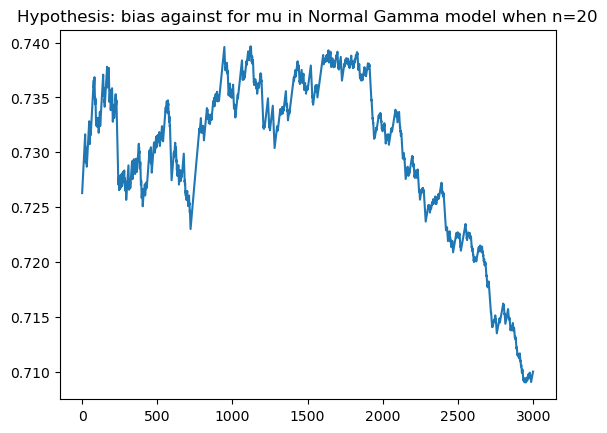

In [27]:
burn = 1000

bias_against_mu = idata.posterior['logRB_mu'].values.ravel()<=0
t_mu = bias_against_mu.shape[0]
bias_against_mci_mu = bias_against_mu.cumsum()/np.arange(1,t_mu+1)
plt.plot(bias_against_mci_mu[burn:], label='Bias Against (Analytical)')
plt.title("Hypothesis: bias against for mu in Normal Gamma model when n={}".format(n))

Text(0.5, 1.0, 'Hypothesis: bias against for phi in Normal Gamma model when n=20')

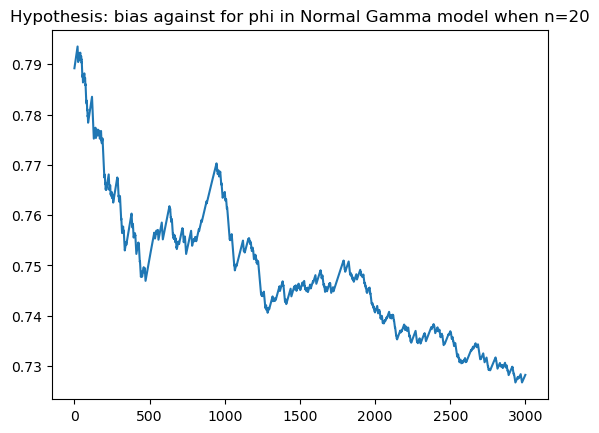

In [28]:
bias_against_phi = idata.posterior['logRB_phi'].values.ravel()<=0
t_phi = bias_against_phi.shape[0]
bias_against_mci_phi = bias_against_phi.cumsum()/np.arange(1,t_phi+1)
plt.plot(bias_against_mci_phi[burn:], label='Bias Against (Analytical)')
plt.title("Hypothesis: bias against for phi in Normal Gamma model when n={}".format(n))

C:\Users\23639\AppData\Local\Temp\ipykernel_18528\1764314744.py:10: RuntimeWarning: divide by zero encountered in log
  marginal_likelihoods_mu = np.log(np.exp(marginal_likelihoods_mu.sum(axis=2)).mean(axis=-1).ravel())


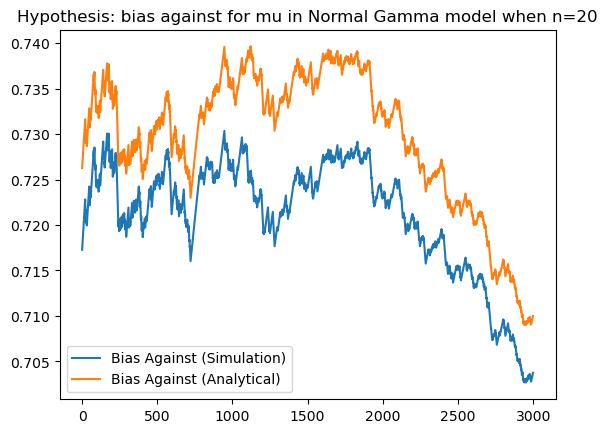

In [29]:
use = 1000
x_values = idata.posterior['x_'].values
marginal_likelihoods_mu = np.zeros(list(x_values.shape) + [use])

# Getting likelihoods for each x_ under each theta_
for i, m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoods_mu[:, :, :, i] = normal_logp_np(x_values, m, 1/phi0**0.5)
    
# Summing the log likelihoods and then taking the average over the parameter samples
marginal_likelihoods_mu = np.log(np.exp(marginal_likelihoods_mu.sum(axis=2)).mean(axis=-1).ravel())

# Simulation
bias_against_ml_mu = (idata.posterior['likelihood_pd'].values.ravel()-marginal_likelihoods_mu) <= 0
bias_against_ml_mci_mu = bias_against_ml_mu.cumsum()/np.arange(1,t_mu+1)


plt.plot(bias_against_ml_mci_mu[burn:], label='Bias Against (Simulation)')
plt.plot(bias_against_mci_mu[burn:], label='Bias Against (Analytical)')
plt.title("Hypothesis: bias against for mu in Normal Gamma model when n={}".format(n))
plt.legend()

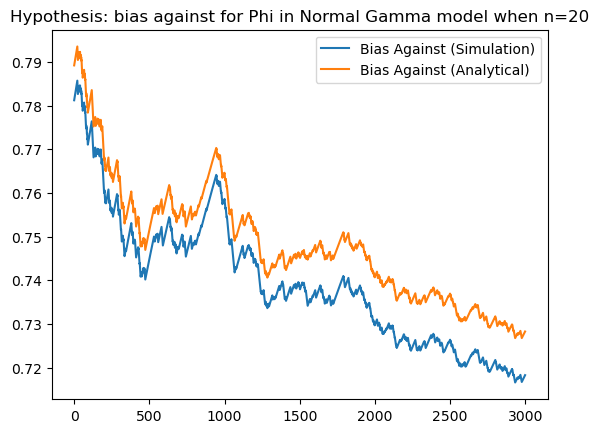

In [30]:

marginal_likelihoods_phi = np.zeros(list(x_values.shape) + [use])

# Getting likelihoods for each x_ under each theta_
for i, m in enumerate(idata.posterior['phi_'].values.ravel()[:use]):
    marginal_likelihoods_phi[:, :, :, i] = normal_logp_np(x_values, mu0, 1/m**0.5)
    
# Summing the log likelihoods and then taking the average over the parameter samples
marginal_likelihoods_phi = np.log(np.exp(marginal_likelihoods_phi.sum(axis=2)).mean(axis=-1).ravel())

# Simulation
bias_against_ml_phi = (idata.posterior['likelihood_pd'].values.ravel()-marginal_likelihoods_phi) <= 0
bias_against_ml_mci_phi = bias_against_ml_phi.cumsum()/np.arange(1,t_phi+1)


plt.plot(bias_against_ml_mci_phi[burn:], label='Bias Against (Simulation)')
plt.plot(bias_against_mci_phi[burn:], label='Bias Against (Analytical)')
plt.title("Hypothesis: bias against for Phi in Normal Gamma model when n={}".format(n))
plt.legend()

### Estimation

In [49]:
with pm.Model() as m_against_estimation:
   
    mu_ = pm.Normal('mu_', mu=mu_prior_mu, sigma=mu_prior_sigma, shape=1)    
    phi_ = pm.Gamma("phi_", alpha = alpha0, beta = beta0, shape = 1)
    
    # Bias against
    x_ = pm.Normal('x_', mu=mu_, tau=phi_, shape=n) 
    
    # Prior predictive data density evaluations
    prior_pd_mu = pm.Deterministic("prior_pd_mu", normal_logp_pm(mu_,mu_prior_mu,mu_prior_sigma))
    prior_pd_phi = pm.Deterministic("prior_pd_phi", pm.logp(pm.Gamma.dist(alpha=alpha0, beta=beta0),phi_))
    
    # Posterior calculations
    posterior_tau = (1/mu_prior_sigma**2 + n*phi_)
    posterior_mu = (mu_prior_mu/mu_prior_sigma**2 + phi_*pm.math.sum(x_))/posterior_tau
    posterior_pd_mu = pm.Deterministic("posterior_pd_mu", pm.logp(pm.Normal.dist(mu = posterior_mu, tau = posterior_tau),mu_))
    
    posterior_alpha = alpha0 + n/2
    posterior_beta = beta0 + pm.math.sum((x_-mu_)**2)/2
    posterior_pd_phi = pm.Deterministic("posterior_pd_phi", pm.logp(pm.Gamma.dist(alpha=posterior_alpha, beta=posterior_beta),phi_))

    # log RB ratio
    logRB_mu = pm.Deterministic("logRB_mu", posterior_pd_mu - prior_pd_mu)
    logRB_phi = pm.Deterministic("logRB_phi", posterior_pd_phi - prior_pd_phi)
    
    #likelihood_pd = pm.Deterministic("likelihood_pd", normal_logpp_pm(x_,mu0,1/phi0**(1/2)).sum())
    likelihood_pd = pm.Deterministic("likelihood_pd", normal_logp_pm(x_,mu_,1/phi_**0.5).sum())
    # Sample from the model
    idata_ae = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_, phi_, x_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


C:\Users\23639\AppData\Local\Temp\ipykernel_14904\379876557.py:18: RuntimeWarning: divide by zero encountered in log
  marginal_likelihoods_mu = np.log(np.exp(marginal_likelihoods_mu.sum(axis=2)).mean(axis=-1).ravel())


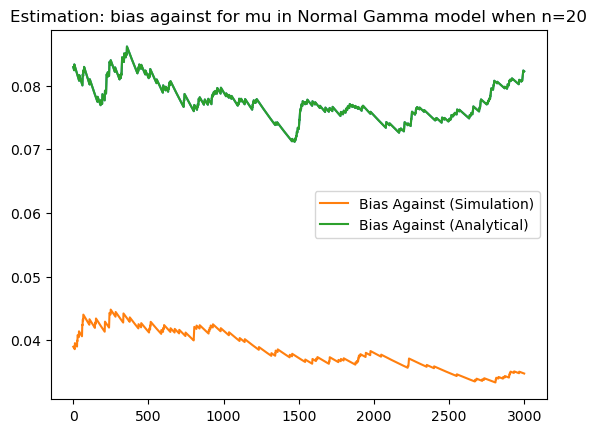

In [50]:
use = 1000
burn = 1000

#Analytics
bias_against_mu = idata_ae.posterior['logRB_mu'].values.ravel()<=0
t_mu = bias_against_mu.shape[0]
bias_against_mci_mu = bias_against_mu.cumsum()/np.arange(1,t_mu+1)
plt.plot(bias_against_mci_mu[burn:]); 

x_values = idata_ae.posterior['x_'].values
marginal_likelihoods_mu = np.zeros(list(x_values.shape) + [use])

# Getting likelihoods for each x_ under each theta_
for i, m in enumerate(idata_ae.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoods_mu[:, :, :, i] = normal_logp_np(x_values, m, 1/phi0**0.5)
    
# Summing the log likelihoods and then taking the average over the parameter samples
marginal_likelihoods_mu = np.log(np.exp(marginal_likelihoods_mu.sum(axis=2)).mean(axis=-1).ravel())

# Simulation
bias_against_ml_mu = (idata_ae.posterior['likelihood_pd'].values.ravel()-marginal_likelihoods_mu) <= 0
bias_against_ml_mci_mu = bias_against_ml_mu.cumsum()/np.arange(1,t_mu+1)


plt.plot(bias_against_ml_mci_mu[burn:], label='Bias Against (Simulation)')
plt.plot(bias_against_mci_mu[burn:], label='Bias Against (Analytical)')
plt.title("Estimation: bias against for mu in Normal Gamma model when n={}".format(n))
plt.legend()

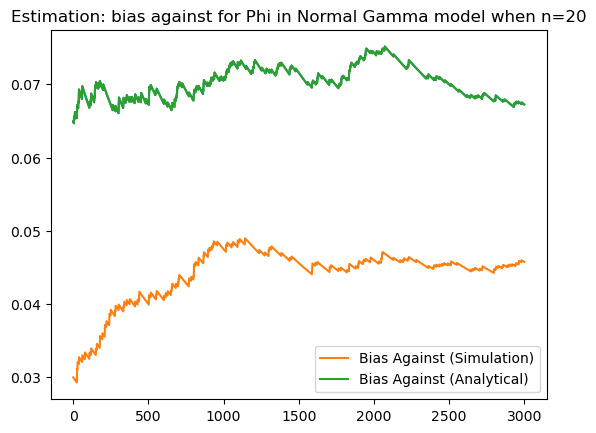

In [52]:
bias_against_phi = idata_ae.posterior['logRB_phi'].values.ravel()<=0
t_phi = bias_against_phi.shape[0]
bias_against_mci_phi = bias_against_phi.cumsum()/np.arange(1,t_phi+1)
plt.plot(bias_against_mci_phi[burn:]); 

marginal_likelihoods_phi = np.zeros(list(x_values.shape) + [use])

# Getting likelihoods for each x_ under each theta_
for i, m in enumerate(idata_ae.posterior['phi_'].values.ravel()[:use]):
    marginal_likelihoods_phi[:, :, :, i] = normal_logp_np(x_values, mu0, 1/m**0.5)
    
# Summing the log likelihoods and then taking the average over the parameter samples
marginal_likelihoods_phi = np.log(np.exp(marginal_likelihoods_phi.sum(axis=2)).mean(axis=-1).ravel())

# Simulation
bias_against_ml_phi = (idata_ae.posterior['likelihood_pd'].values.ravel()-marginal_likelihoods_phi) <= 0
bias_against_ml_mci_phi = bias_against_ml_phi.cumsum()/np.arange(1,t_phi+1)


plt.plot(bias_against_ml_mci_phi[burn:], label='Bias Against (Simulation)')
plt.plot(bias_against_mci_phi[burn:], label='Bias Against (Analytical)')
plt.title("Estimation: bias against for Phi in Normal Gamma model when n={}".format(n))
plt.legend()

## Bias in Favor

In [6]:
infavour_d = {}
with pm.Model() as infavour_m:
   
    mu_ = pm.Normal('mu_', mu=mu_prior_mu, sigma=mu_prior_sigma, shape=1)    
    phi_ = pm.Gamma("phi_", alpha = alpha0, beta = beta0, shape = 1)

    # Prior predictive data density evaluations
    prior_pd_mu = pm.Deterministic("prior_pd_mu", normal_logp_pm(mu0,mu_prior_mu,mu_prior_sigma))
    prior_pd_phi = pm.Deterministic("prior_pd_phi", pm.logp(pm.Gamma.dist(alpha=alpha0, beta=beta0),phi0))

    
    for i in range(-50, 51):
        mu_t = mu0 + i/100
        phi_t = phi0 + (0.25 - (i**2)/10000)**0.5
        infavour_d[f'x_{i+50}'] = pm.Normal(f'x_{i+50}', mu=mu_t, tau=phi_t, shape=n) 
        
        # Posterior calculations
        posterior_tau = (1/mu_prior_sigma**2 + n*phi0)
        posterior_mu = (mu_prior_mu/mu_prior_sigma**2 + phi0*pm.math.sum(infavour_d[f'x_{i+50}']))/posterior_tau
        infavour_d[f'posterior_pd_mu_{i+50}'] = pm.Deterministic(f'posterior_pd_mu_{i+50}', pm.logp(pm.Normal.dist(mu = posterior_mu, tau = posterior_tau),mu0))
        
        posterior_alpha = alpha0 + n/2
        posterior_beta = beta0 + pm.math.sum((infavour_d[f'x_{i+50}']-mu0)**2)/2
        infavour_d[f'posterior_pd_phi_{i+50}'] = pm.Deterministic(f'posterior_pd_phi_{i+50}', pm.logp(pm.Gamma.dist(alpha=posterior_alpha, beta=posterior_beta),phi0))

        #log RB ratio
        infavour_d[f'logRB_mu_{i+50}']= pm.Deterministic(f'logRB_mu_{i+50}', infavour_d[f'posterior_pd_mu_{i+50}'] - prior_pd_mu)
        infavour_d[f'logRB_phi_{i+50}'] = pm.Deterministic(f'logRB_phi_{i+50}', infavour_d[f'posterior_pd_phi_{i+50}'] - prior_pd_phi)
    
        #likelihood_pd = pm.Deterministic("likelihood_pd", normal_logpp_pm(x_,mu0,1/phi0**(1/2)).sum())
        #likelihood_pd = pm.Deterministic("likelihood_pd", normal_logp_pm(x_,mu0,1/phi0**0.5).sum())
    # Sample from the model
    infavour = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_, phi_, x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20, x_21, x_22, x_23, x_24, x_25, x_26, x_27, x_28, x_29, x_30, x_31, x_32, x_33, x_34, x_35, x_36, x_37, x_38, x_39, x_40, x_41, x_42, x_43, x_44, x_45, x_46, x_47, x_48, x_49, x_50, x_51, x_52, x_53, x_54, x_55, x_56, x_57, x_58, x_59, x_60, x_61, x_62, x_63, x_64, x_65, x_66, x_67, x_68, x_69, x_70, x_71, x_72, x_73, x_74, x_75, x_76, x_77, x_78, x_79, x_80, x_81, x_82, x_83, x_84, x_85, x_86, x_87, x_88, x_89, x_90, x_91, x_92, x_93, x_94, x_95, x_96, x_97, x_98, x_99, x_100]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 1.0, 'Hypothesis: bias in favour for $\\mu$ in range (-50, 51)when n=20')

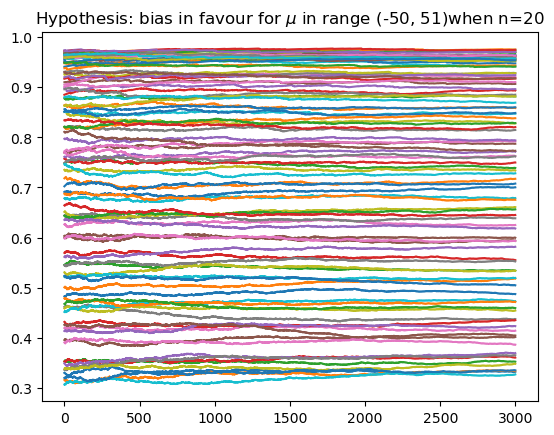

In [15]:
burn = 1000
for i in range(-50, 51):
    bias_infavour_mu = infavour.posterior[f'logRB_mu_{i+50}'].values.ravel()>=0
    t_mu = bias_infavour_mu.shape[0]
    bias_infavour_mci_mu = bias_infavour_mu.cumsum()/np.arange(1,t_mu+1)
    plt.plot(bias_infavour_mci_mu[burn:], label = "i = {}".format(i))
    
plt.title("Hypothesis: bias in favour for $\mu$ in range (-50, 51)when n={}".format(n))
#plt.legend()

C:\Users\23639\AppData\Local\Temp\ipykernel_2736\1541123427.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 101)


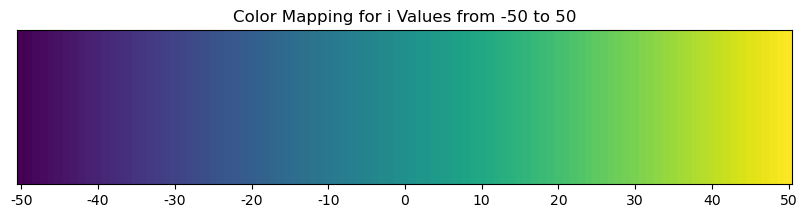

In [33]:
from matplotlib.colors import Normalize

# Define the range of i values
i_values = np.arange(-50, 51)

# Create a colormap and normalization instance
cmap = cm.get_cmap('viridis', 101)
norm = Normalize(vmin=-50, vmax=50)

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 2))

# Create a horizontal gradient image
gradient = np.linspace(-50, 50, 101).reshape(1, -1)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
ax.imshow(gradient, aspect='auto', cmap=cmap, norm=norm)

# Set the ticks and labels
ax.set_xticks(np.linspace(0, 100, 11))
ax.set_xticklabels(np.arange(-50, 51, 10))
ax.set_yticks([])

# Set the title
ax.set_title('Color Mapping for i Values from -50 to 50')

# Show the plot
plt.show()

C:\Users\23639\AppData\Local\Temp\ipykernel_2736\2211854202.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 101)  # Use a colormap with 101 distinct colors


Text(0.5, 1.0, 'Hypothesis: bias in favour for $\\mu$ in range (-50, 51)when n=20')

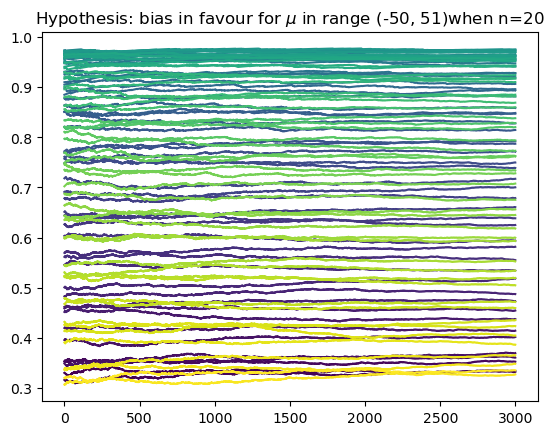

In [27]:
burn = 1000
cmap = cm.get_cmap('viridis', 101)  # Use a colormap with 101 distinct colors
for i in range(-50, 51):
    bias_infavour_mu = infavour.posterior[f'logRB_mu_{i+50}'].values.ravel()>=0
    t_mu = bias_infavour_mu.shape[0]
    bias_infavour_mci_mu = bias_infavour_mu.cumsum()/np.arange(1,t_mu+1)
    color = cmap(i + 50)  # Map the value of i to a color
    plt.plot(bias_infavour_mci_mu[burn:], label = "i = {}".format(i), color = color)
    
plt.title("Hypothesis: bias in favour for $\mu$ in range (-50, 51)when n={}".format(n))
#plt.legend()

Text(0.5, 1.0, 'Hypothesis: bias in favour for $\\mu$ in range (-25, 25) when n=20')

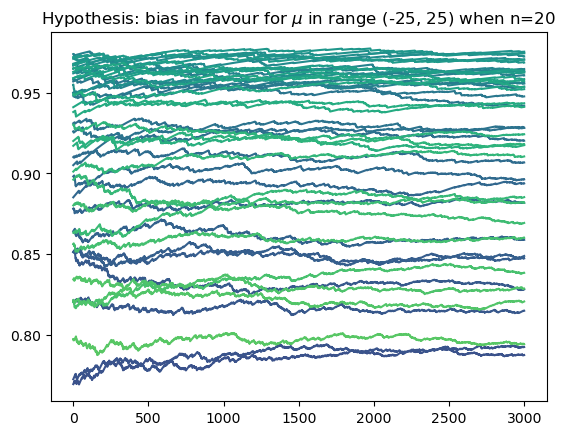

In [36]:

for i in range(-25, 25):
    bias_infavour_mu = infavour.posterior[f'logRB_mu_{i+50}'].values.ravel()>=0
    t_mu = bias_infavour_mu.shape[0]
    bias_infavour_mci_mu = bias_infavour_mu.cumsum()/np.arange(1,t_mu+1)
    color = cmap(i + 50)  # Map the value of i to a color
    plt.plot(bias_infavour_mci_mu[burn:], label = "i = {}".format(i), color = color)
    
plt.title("Hypothesis: bias in favour for $\mu$ in range (-25, 25) when n={}".format(n))
#plt.legend()

Text(0.5, 1.0, 'Hypothesis: bias in favour for $\\phi$ in range (-50, 51) when n=20')

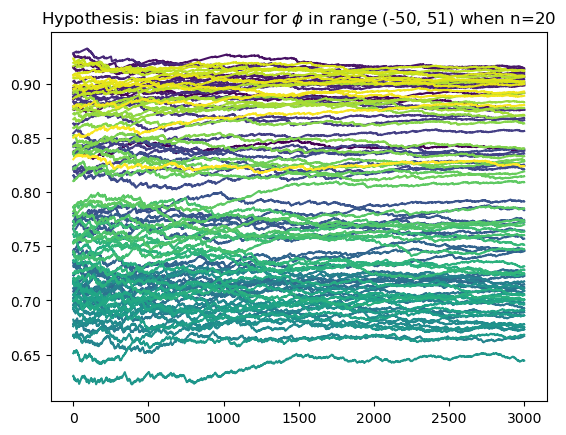

In [37]:

for i in range(-50, 51):
    bias_infavour_phi = infavour.posterior[f'logRB_phi_{i+50}'].values.ravel()>=0
    t_phi = bias_infavour_phi.shape[0]
    bias_infavour_mci_phi = bias_infavour_phi.cumsum()/np.arange(1,t_phi+1)
    color = cmap(i + 50)  # Map the value of i to a color
    plt.plot(bias_infavour_mci_phi[burn:], label = "i = {}".format(i), color = color)
    
plt.title("Hypothesis: bias in favour for $\phi$ in range (-50, 51) when n={}".format(n))
#plt.legend()

Text(0.5, 1.0, 'Hypothesis: bias in favour for $\\phi$ in range (-25, 25) when n=20')

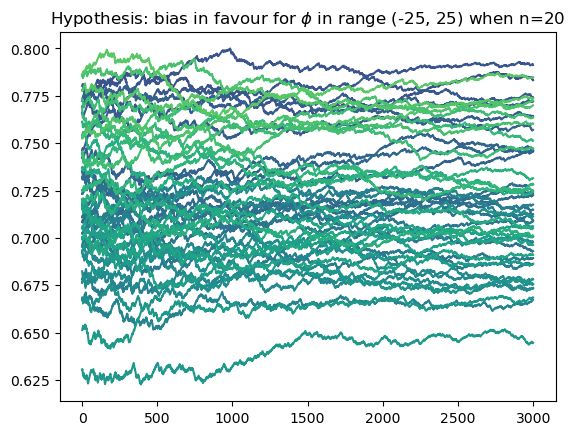

In [38]:

for i in range(-25, 25):
    bias_infavour_phi = infavour.posterior[f'logRB_phi_{i+50}'].values.ravel()>=0
    t_phi = bias_infavour_phi.shape[0]
    bias_infavour_mci_phi = bias_infavour_phi.cumsum()/np.arange(1,t_phi+1)
    color = cmap(i + 50)  # Map the value of i to a color
    plt.plot(bias_infavour_mci_phi[burn:], label = "i = {}".format(i), color = color)
    
plt.title("Hypothesis: bias in favour for $\phi$ in range (-25, 25) when n={}".format(n))
#plt.legend()

Text(0.5, 1.0, 'Hypothesis: bias in favour for mu in Normal Gamma model when n=20')

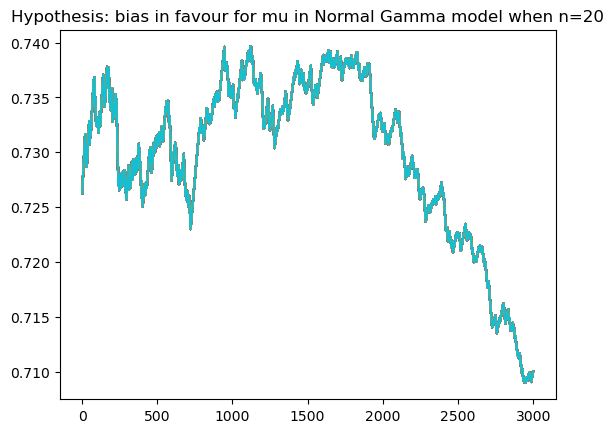

In [45]:
burn = 1000
for i in range(-50, 50):
    bias_infavour_mu = infavour.posterior[f'logRB_mu_{i+50}'].values.ravel()>=0
    t_mu = bias_infavour_mu.shape[0]
    bias_infavour_mci_mu = bias_infavour_mu.cumsum()/np.arange(1,t_mu+1)
    plt.plot(bias_infavour_mci_mu[burn:], label = "i = {}".format(i))
    
plt.title("Hypothesis: bias in favour for $\mui$ in Normal Gamma model when n={}".format(n))
plt.legend()

Text(0.5, 1.0, 'Hypothesis: bias in favour for phi in Normal Gamma model when n=20')

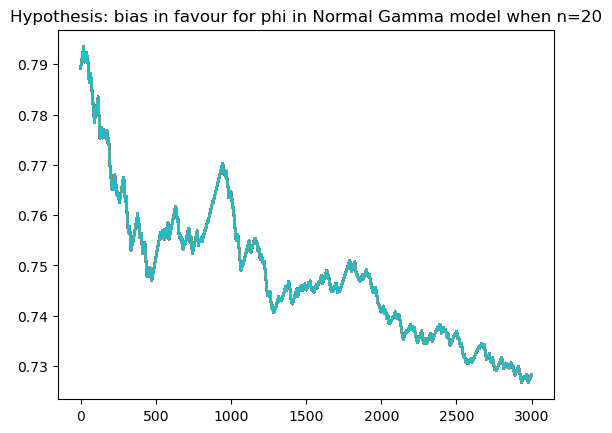

In [46]:
burn = 1000
for i in range(-50, 50):
    bias_infavour_phi_p = infavour.posterior[f'logRB_phi_{i+50}'].values.ravel()>=0
    t_phi = bias_infavour_phi_p.shape[0]
    bias_infavour_mci_phi = bias_infavour_phi.cumsum()/np.arange(1,t_phi+1)
    plt.plot(bias_infavour_mci_phi[burn:], label = "i = {}".format(i))
    
plt.title("Hypothesis: bias in favour for $\phi$ in Normal Gamma model when n={}".format(n))

#### Consider Both situation(+ & -) for phi

In [18]:
infavour_d2 = {}
with pm.Model() as infavour_m2:
   
    mu_ = pm.Normal('mu_', mu=mu_prior_mu, sigma=mu_prior_sigma, shape=1)    
    phi_ = pm.Gamma("phi_", alpha = alpha0, beta = beta0, shape = 1)

    # Prior predictive data density evaluations
    prior_pd_mu = pm.Deterministic("prior_pd_mu", normal_logp_pm(mu0,mu_prior_mu,mu_prior_sigma))
    prior_pd_phi = pm.Deterministic("prior_pd_phi", pm.logp(pm.Gamma.dist(alpha=alpha0, beta=beta0),phi0))

    
    for i in range(-50, 51):
        mu_d = mu0 + i/100

    # add
        phi_d_p = phi0 + (0.25 - (i**2)/10000)**0.5
        infavour_d2[f'x_p_{i+50}'] = pm.Normal(f'x_p_{i+50}', mu=mu_d, tau=phi_d_p, shape=n) 
        
        # Posterior calculations
        posterior_tau = (1/mu_prior_sigma**2 + n*phi0)
        posterior_mu = (mu_prior_mu/mu_prior_sigma**2 + phi0*pm.math.sum(infavour_d2[f'x_p_{i+50}']))/posterior_tau
        infavour_d2[f'posterior_pd_mu_p_{i+50}'] = pm.Deterministic(f'posterior_pd_mu_p_{i+50}', pm.logp(pm.Normal.dist(mu = posterior_mu, tau = posterior_tau),mu0))
            
        posterior_alpha = alpha0 + n/2
        posterior_beta = beta0 + pm.math.sum((infavour_d2[f'x_p_{i+50}']-mu0)**2)/2
        infavour_d2[f'posterior_pd_phi_p_{i+50}'] = pm.Deterministic(f'posterior_pd_phi_p_{i+50}', pm.logp(pm.Gamma.dist(alpha=posterior_alpha, beta=posterior_beta),phi0))
    
        #log RB ratio
        infavour_d2[f'logRB_mu_p_{i+50}']= pm.Deterministic(f'logRB_mu_p_{i+50}', infavour_d2[f'posterior_pd_mu_p_{i+50}'] - prior_pd_mu)
        infavour_d2[f'logRB_phi_p_{i+50}'] = pm.Deterministic(f'logRB_phi_p_{i+50}', infavour_d2[f'posterior_pd_phi_p_{i+50}'] - prior_pd_phi)
    
    # minus
        phi_d_n = phi0 - (0.25 - (i**2)/10000)**0.5
        infavour_d2[f'x_n_{i+50}'] = pm.Normal(f'x_n_{i+50}', mu=mu_d, tau=phi_d_n, shape=n)
        
            # Posterior calculations
        posterior_tau = (1/mu_prior_sigma**2 + n*phi0)
        posterior_mu = (mu_prior_mu/mu_prior_sigma**2 + phi0*pm.math.sum(infavour_d2[f'x_n_{i+50}']))/posterior_tau
        infavour_d2[f'posterior_pd_mu_n_{i+50}'] = pm.Deterministic(f'posterior_pd_mu_n_{i+50}', pm.logp(pm.Normal.dist(mu = posterior_mu, tau = posterior_tau),mu0))
            
        posterior_alpha = alpha0 + n/2
        posterior_beta = beta0 + pm.math.sum((infavour_d2[f'x_n_{i+50}']-mu0)**2)/2
        infavour_d2[f'posterior_pd_phi_n_{i+50}'] = pm.Deterministic(f'posterior_pd_phi_n_{i+50}', pm.logp(pm.Gamma.dist(alpha=posterior_alpha, beta=posterior_beta),phi0))
    
        #log RB ratio
        infavour_d2[f'logRB_mu_n_{i+50}']= pm.Deterministic(f'logRB_mu_n_{i+50}', infavour_d2[f'posterior_pd_mu_n_{i+50}'] - prior_pd_mu)
        infavour_d2[f'logRB_phi_n_{i+50}'] = pm.Deterministic(f'logRB_phi_n_{i+50}', infavour_d2[f'posterior_pd_phi_n_{i+50}'] - prior_pd_phi)
    
    
    
    #likelihood_pd = pm.Deterministic("likelihood_pd", normal_logpp_pm(x_,mu0,1/phi0**(1/2)).sum())
        #likelihood_pd = pm.Deterministic("likelihood_pd", normal_logp_pm(x_,mu0,1/phi0**0.5).sum())
    # Sample from the model
    infavour2 = pm.sample(500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_, phi_, x_p_0, x_n_0, x_p_1, x_n_1, x_p_2, x_n_2, x_p_3, x_n_3, x_p_4, x_n_4, x_p_5, x_n_5, x_p_6, x_n_6, x_p_7, x_n_7, x_p_8, x_n_8, x_p_9, x_n_9, x_p_10, x_n_10, x_p_11, x_n_11, x_p_12, x_n_12, x_p_13, x_n_13, x_p_14, x_n_14, x_p_15, x_n_15, x_p_16, x_n_16, x_p_17, x_n_17, x_p_18, x_n_18, x_p_19, x_n_19, x_p_20, x_n_20, x_p_21, x_n_21, x_p_22, x_n_22, x_p_23, x_n_23, x_p_24, x_n_24, x_p_25, x_n_25, x_p_26, x_n_26, x_p_27, x_n_27, x_p_28, x_n_28, x_p_29, x_n_29, x_p_30, x_n_30, x_p_31, x_n_31, x_p_32, x_n_32, x_p_33, x_n_33, x_p_34, x_n_34, x_p_35, x_n_35, x_p_36, x_n_36, x_p_37, x_n_37, x_p_38, x_n_38, x_p_39, x_n_39, x_p_40, x_n_40, x_p_41, x_n_41, x_p_42, x_n_42, x_p_43, x_n_43, x_p_44, x_n_44, x_p_45, x_n_45, x_p_46, x_n_46, x_p_47, x_n_47, x_p_48, x_n_48, x_p_49, x_n_49, x_p_50, x_n_50, x_p_51, x_n_51, x_p_52, x_n_52, x_p_53, x_n_53, x_p_54, x_n_54, x_p

Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 218 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 1.0, 'Hypothesis: bias in favour for $\\mu$ in Normal Gamma model when n=20')

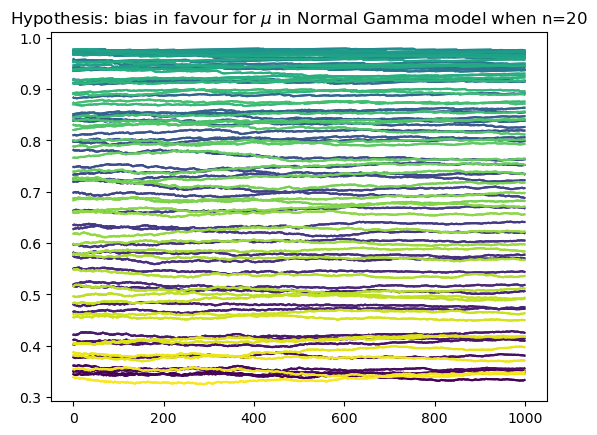

In [48]:
burn = 1000
for i in range(-50, 50):
    bias_against_mu_p = infavour2.posterior[f'logRB_mu_p_{i+50}'].values.ravel()>=0
    t_mu_p = bias_against_mu_p.shape[0]
    bias_against_mci_mu_p = bias_against_mu_p.cumsum()/np.arange(1,t_mu_p+1)
    color = cmap(i + 50)  # Map the value of i to a color
    plt.plot(bias_against_mci_mu_p[burn:], label = "i = {} for plus".format(i), color = color)
    
    bias_against_mu_n = infavour2.posterior[f'logRB_mu_n_{i+50}'].values.ravel()>=0
    t_mu_n = bias_against_mu_n.shape[0]
    bias_against_mci_mu_n = bias_against_mu_n.cumsum()/np.arange(1,t_mu_n+1)
    plt.plot(bias_against_mci_mu_p[burn:], label = "i = {} for minus".format(i), color = color)
    
plt.title("Hypothesis: bias in favour for $\mu$ in Normal Gamma model when n={}".format(n))
#plt.legend()

__The bias in favour is the same for the same $\mu$ with different  $\phi$.__

Text(0.5, 1.0, 'Hypothesis: bias in favour for $\\mu$ in range (-25, 25) when n=20')

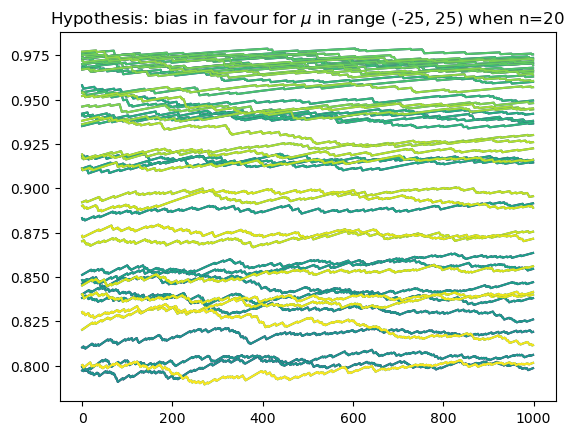

In [47]:
#

burn = 1000
for i in range(-25, 25):
    color = cmap(i + 25)
    bias_against_mu_p = infavour2.posterior[f'logRB_mu_p_{i+50}'].values.ravel()>=0
    t_mu_p = bias_against_mu_p.shape[0]
    bias_against_mci_mu_p = bias_against_mu_p.cumsum()/np.arange(1,t_mu_p+1)
    plt.plot(bias_against_mci_mu_p[burn:], label = "i = {} for plus".format(i), color = color)
    
    color = cmap(i + 75)
    bias_against_mu_n = infavour2.posterior[f'logRB_mu_n_{i+50}'].values.ravel()>=0
    t_mu_n = bias_against_mu_n.shape[0]
    bias_against_mci_mu_n = bias_against_mu_n.cumsum()/np.arange(1,t_mu_n+1)
    plt.plot(bias_against_mci_mu_p[burn:], label = "i = {} for minus".format(i), color = color)
    
plt.title("Hypothesis: bias in favour for $\mu$ in range (-25, 25) when n={}".format(n))
#plt.legend()

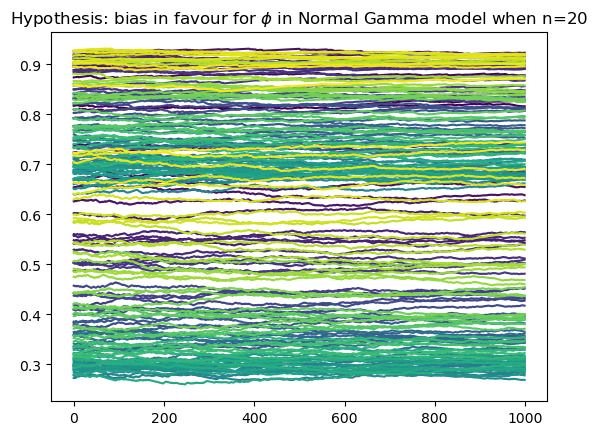

In [41]:

for i in range(-50, 50):
    color = cmap(i + 50)
    bias_against_phi_p = infavour2.posterior[f'logRB_phi_p_{i+50}'].values.ravel()>=0
    t_phi_p = bias_against_phi_p.shape[0]
    bias_against_mci_phi_p = bias_against_phi_p.cumsum()/np.arange(1,t_phi_p+1)
    plt.plot(bias_against_mci_phi_p[burn:], color = color)

    bias_against_phi_n = infavour2.posterior[f'logRB_phi_n_{i+50}'].values.ravel()>=0
    t_phi_n = bias_against_phi_n.shape[0]
    bias_against_mci_phi_n = bias_against_phi_n.cumsum()/np.arange(1,t_phi_n+1)
    plt.plot(bias_against_mci_phi_n[burn:], color = color)
    
    plt.title("Hypothesis: bias in favour for $\phi$ in Normal Gamma model when n={}".format(n))

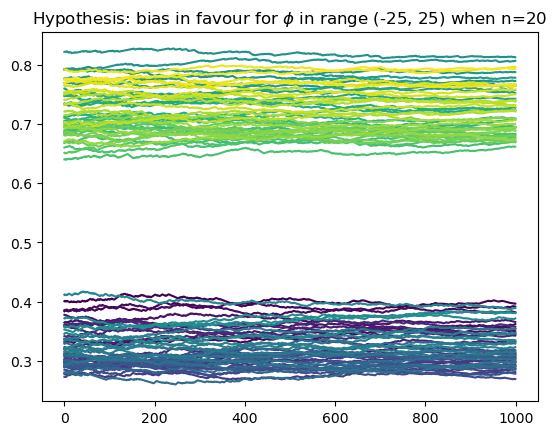

In [43]:
## for phi + delta, bias in favor is large

for i in range (-25, 25):
    color = cmap(i + 75)
    bias_against_phi_p = infavour2.posterior[f'logRB_phi_p_{i+50}'].values.ravel()>=0
    t_phi_p = bias_against_phi_p.shape[0]
    bias_against_mci_phi_p = bias_against_phi_p.cumsum()/np.arange(1,t_phi_p+1)
    plt.plot(bias_against_mci_phi_p[burn:], color = color)
    color = cmap(i + 25)
    bias_against_phi_n = infavour2.posterior[f'logRB_phi_n_{i+50}'].values.ravel()>=0
    t_phi_n = bias_against_phi_n.shape[0]
    bias_against_mci_phi_n = bias_against_phi_n.cumsum()/np.arange(1,t_phi_n+1)
    plt.plot(bias_against_mci_phi_n[burn:], color = color)
    
    plt.title("Hypothesis: bias in favour for $\phi$ in range (-25, 25) when n={}".format(n))